## Importing Libraries

In [1]:
# Utility
import numpy as np
import pandas as pd
import pickle

# Plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

## Data Import

In [4]:
df = pd.read_csv('Cyberbullying Classification/cyberbullying_tweets.csv')
display(df.sample(5))
df.shape

,tweet_text,cyberbullying_type
13328,"Rape jokes aren't funny. ""Gay"" jokes aren't fu...",gender
6559,"Paula, Kiersten and LJ's song about bullying. ...",not_cyberbullying
29225,Just in case anyone is down for some meatballs...,other_cyberbullying
43759,"“@tayyoung_: FUCK OBAMA, dumb ass nigger” fuck...",ethnicity
39519,I was bullied by my own teacher until I fainte...,age


(47692, 2)

In [5]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [6]:
for tweet in df.sample(5)['tweet_text']:
    print(tweet +'\n')

Pity the tide didn't come in and sink Annie's meatballs #MKR

@semzyxx Now, since you claim that Islam limits age of marriage, but produce no verses to back up your lies, you are blocked.

If people bully me in school I’ll be able to flex my Twitter follower count and they won’t bully me because I’m too cool

Some where in the world right now there is a thirsty Christian woman hunting at a church singles event.

This is a conversation I had with one of Chums friends earlier today. http://t.co/VsDCnNjGwx



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [8]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


## Data Pre-processing

**Looking for null and duplicate values**

In [9]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [10]:
df['tweet_text'].duplicated().sum()

1675

Dropping duplicates

In [11]:
df.drop_duplicates('tweet_text', inplace=True, ignore_index=True)
df['tweet_text'].duplicated().sum()

0

**Checking for balanced classes**

In [12]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64

In [13]:
df = df[df["cyberbullying_type"] != "other_cyberbullying"]
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity'],
      dtype=object)

**Label Encoding the Classes**

In [14]:
cyberbullying_type = ['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity']
encoding_dict = {'not_cyberbullying':0, 'gender':1, 'religion':2, 'age':3, 'ethnicity':4}
df['cyberbullying_type'] = df['cyberbullying_type'].map(encoding_dict)
df.sample(5)

,tweet_text,cyberbullying_type
39908,Imagine you're a colored negro child and you'r...,4
8684,"Racist is an adjective, it isn't a discriminat...",1
36973,The girl that used to bully me in high school ...,3
3302,RT @FeministaJones: I wrote a piece for @TIME ...,0
23253,@Politics_PR @FoxNews Islamic no go zones are ...,2


## NLP Processing

Cleaning the tweets and then processing them to a new column

In [15]:
# Downloading dependencies
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
stopwords_list = stopwords.words('english')
additional_stopwords = ['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's']   # Specific to twitter lingo
stopwords_list.extend(additional_stopwords)
lemmatizer = WordNetLemmatizer()    # Using Lemmatizer instead of Stemmer

Custom defined functions to deep clean the unprocessed tweets


In [17]:
def remove_usernames(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='@']
    return ' '.join(words)

def remove_hashtags(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='#']
    return ' '.join(words)

def remove_links(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[:4]!='http']
    return ' '.join(words) 

def remove_punctuation(tweet):
    for mark in punctuation:
        tweet = tweet.replace(mark, '')
    return tweet

def convert_lowercase(tweet):
    return tweet.lower()

def tokenization(tweet):
    return word_tokenize(tweet)

def remove_stopwords(tok_tweet):
    res = []
    for word in tok_tweet:
        if word not in stopwords_list:
            res.append(word)
    return res

def lemmatize_words(tok_tweet):
    res = []
    for word in tok_tweet:
        res.append(lemmatizer.lemmatize(word))
    return res

In [18]:
# Defining a custom tweet cleaning function
def pre_processing_custom(tweet):
    tweet = remove_usernames(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_links(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

Applying this processing function to our dataset

In [19]:
df['clean_tweets'] = df['tweet_text'].map(pre_processing_custom)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets
16219,Ooooh you are a pudding.I your kneck of the wo...,2,ooooh puddingi kneck wood cant buy non halalme...
37326,"I went to PS. There are as many entitled, snob...",3,went p many entitled snobbish dickhead bitchy ...
9001,"Honestly, rape and racist jokes are worse than...",1,honestly rape racist joke worse gay man ’ bad ...
19798,RT @ProudPatriot101: ▶ Rotherham Rape Scandal ...,2,▶ rotherham rape scandal destroys white privil...
22828,YES!!! A REPUBLICAN CHRISTIAN WOMAN AND SHE KE...,2,yes republican christian woman kept rifle lock...


In [20]:
%pip install tweet-preprocessor
import preprocessor as p

In [21]:
def clean_tweets(tweet):
    tweet = p.clean(tweet)
    return tweet

In [22]:
# Defining the better cleaning function
def pre_processing(tweet):
    tweet = clean_tweets(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

In [23]:
# Clean tweets
df['clean_tweets'] = df['tweet_text'].map(pre_processing)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets
19501,India banned ertugrul. Then idiots would want ...,2,india banned ertugrul idiot would want watch g...
1635,RT @lsarsour: I love you NYC. #MillionsMarchNY...,0,love nyc
11748,RT @BoleynButtz: I believe in equal rights the...,1,believe equal right sexist woman reaction time...
18635,You’re the one bringing up the Quran and suppo...,2,youre one bringing quran supporting iof terror...
39585,my dad is so racist. anytime he hears anything...,4,dad racist anytime hears anything obama say fu...


Checking again for duplicate values

In [24]:
df['clean_tweets'].duplicated().sum()

1217

Removing them

In [25]:
df.drop_duplicates('clean_tweets', inplace=True, ignore_index=True)
df['clean_tweets'].duplicated().sum()

0

In [26]:
df.shape

(38557, 3)

**38557** tweets are remaining

Calculating the total and average word lengths of each tweet

In [27]:
# Total word count of a tweet
df['word_count'] = df['tweet_text'].map(lambda x: len(x.split()))
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count
33449,I didn't get anything out of this interview th...,4,didnt get anything interview suggests trump ag...,37
23664,"She was a really nasty bully, at high school t...",3,really nasty bully high school apparently,11
37912,So when she called all the members in her grou...,4,called member group nigger term endearment lau...,47
3538,Yup totally agree.. Hope they are out soon! #MKR,0,yup totally agree hope soon,9
7766,reasons i hate the guys in my grade: they joke...,1,reason hate guy grade joke disabled rape race ...,49


In [28]:
# Average word length of a tweet
def avg_word_length(tweet):
    words = tweet.split()
    word_count = len(words)
    word_length = 0
    for word in words:
        word_length += len(word)
    avg_length = round(word_length / word_count,2)
    return avg_length

df['avg_word_length'] = df['tweet_text'].map(avg_word_length)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count,avg_word_length
2265,RT @BlackGirlDanger: Re LRT: If you're a cishe...,0,lrt youre cishetdude ask question today shut fuck,21,4.76
18514,@LifeInKhilafah The prophet Mohammed was illit...,2,prophet mohammed illiterate superstition knew ...,16,6.44
5463,okay so tat guy is in my design&amp;engineerin...,0,okay tat guy designampengineering class cool a...,13,4.69
2905,RT @CronkiteSays: VIEWER POLL Do you support b...,0,viewer poll support banning burka country yesr...,19,5.00
17188,This is what happened yesterday! Germany polic...,2,happened yesterday germany police raided shia ...,44,5.36


In [29]:
df = df[df['word_count']>3]
df = df[df['word_count']<100]
df.reset_index(drop=True, inplace=True)
df.shape

(38201, 5)

## Data Visualization

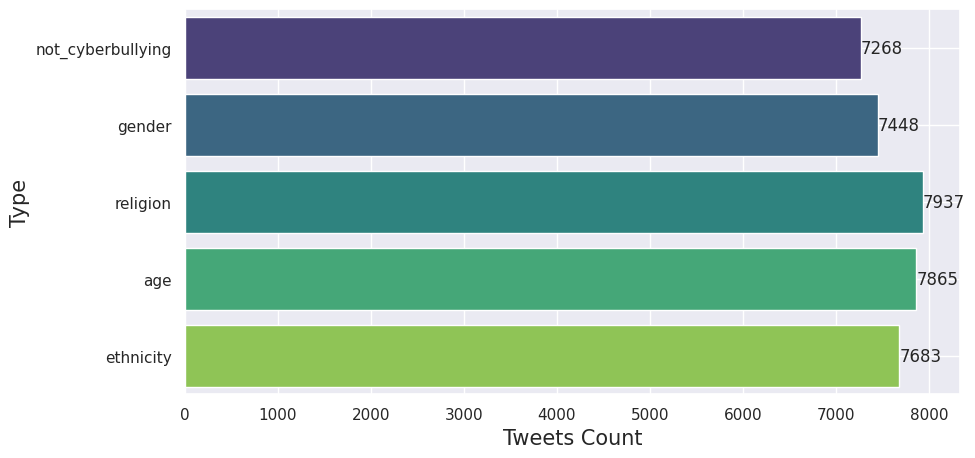

In [30]:
sns.set_theme()
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, y='cyberbullying_type', palette="viridis")
ax.bar_label(ax.containers[0])
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Tweets Count', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

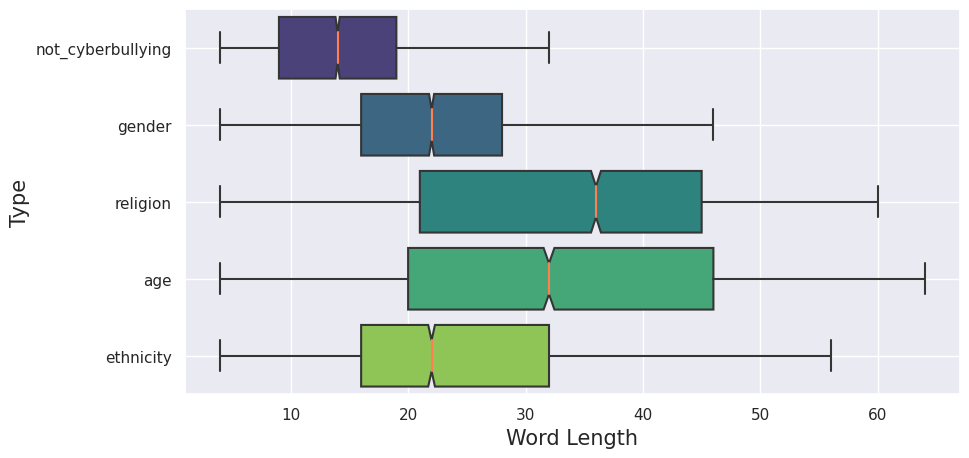

In [31]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='cyberbullying_type', x='word_count', orient='h', showfliers=False, palette='viridis', notch=True, medianprops={"color": "coral"})
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Word Length', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

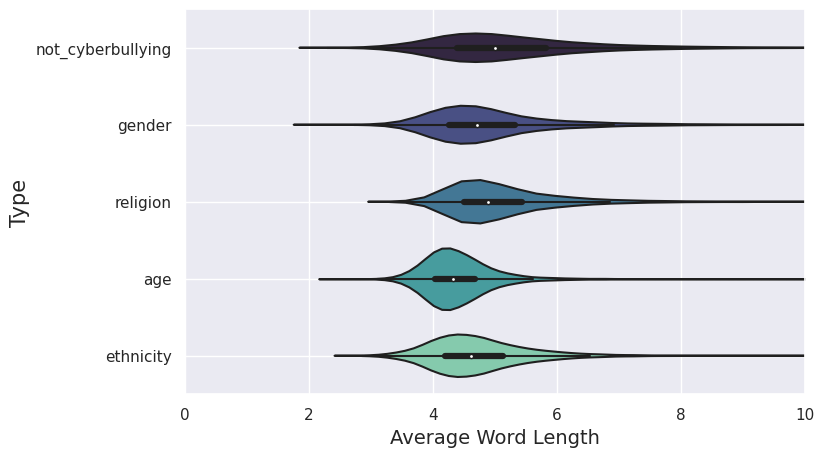

In [32]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, y='cyberbullying_type', x='avg_word_length', orient='h', palette='mako')
plt.xlim(0, 10)
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Average Word Length', size=14)
plt.ylabel('Type', size=15)
plt.grid(color='w')

Text(32.0, 0.5, 'Average Word Length')

<Figure size 800x500 with 0 Axes>

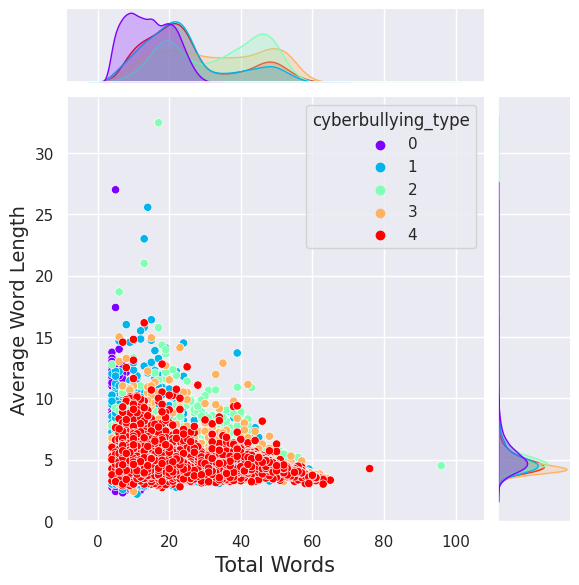

In [33]:
plt.figure(figsize=(8, 5))
sns.jointplot(data=df, y='avg_word_length', x='word_count', hue='cyberbullying_type', palette='rainbow')
plt.xlabel('Total Words', size=15)
plt.ylabel('Average Word Length', size=14)

### **Word Clouds**

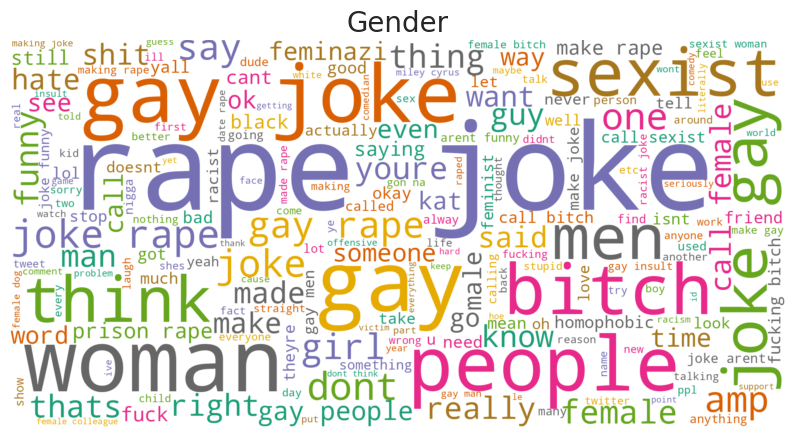

In [34]:
# Gender
plt.figure(figsize=(10, 10))
subset1 = df[df['cyberbullying_type']==1]
text_gender = subset1['clean_tweets'].values
wc1 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_gender))

plt.axis('off')
plt.title("Gender", fontsize=20)
plt.imshow(wc1, interpolation='bilinear')

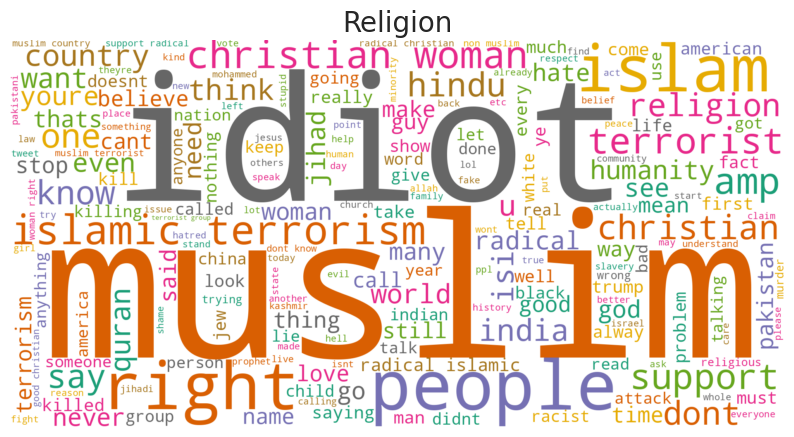

In [35]:
# Religion
plt.figure(figsize=(10, 10))
subset2 = df[df['cyberbullying_type']==2]
text_religion = subset2['clean_tweets'].values
wc2 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_religion))

plt.axis('off')
plt.title("Religion", fontsize=20)
plt.imshow(wc2, interpolation='bilinear')

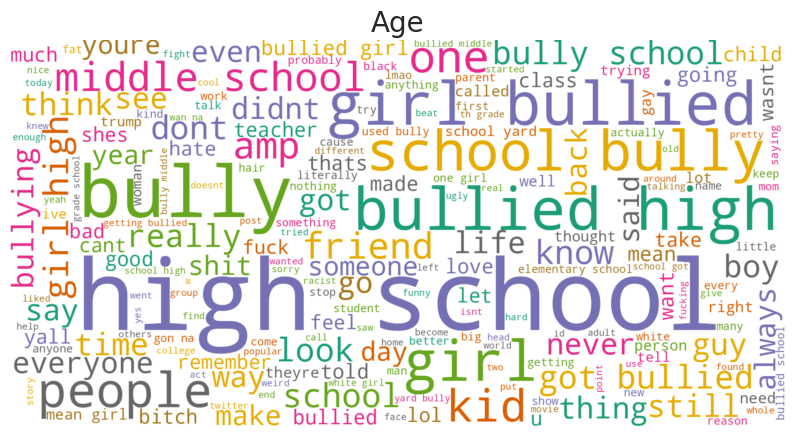

In [36]:
# Age
plt.figure(figsize=(10, 10))
subset3 = df[df['cyberbullying_type']==3]
text_age = subset3['clean_tweets'].values
wc3 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_age))

plt.axis('off')
plt.title("Age", fontsize=20)
plt.imshow(wc3, interpolation='bilinear')

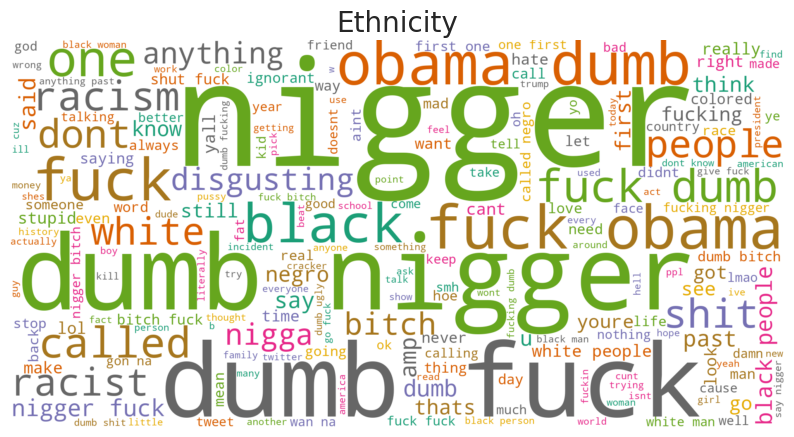

In [37]:
# Ethnicity
plt.figure(figsize=(10, 10))
subset4 = df[df['cyberbullying_type']==4]
text_ethnicity = subset4['clean_tweets'].values
wc4 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_ethnicity))

plt.axis('off')
plt.title("Ethnicity", fontsize=20)
plt.imshow(wc4, interpolation='bilinear')

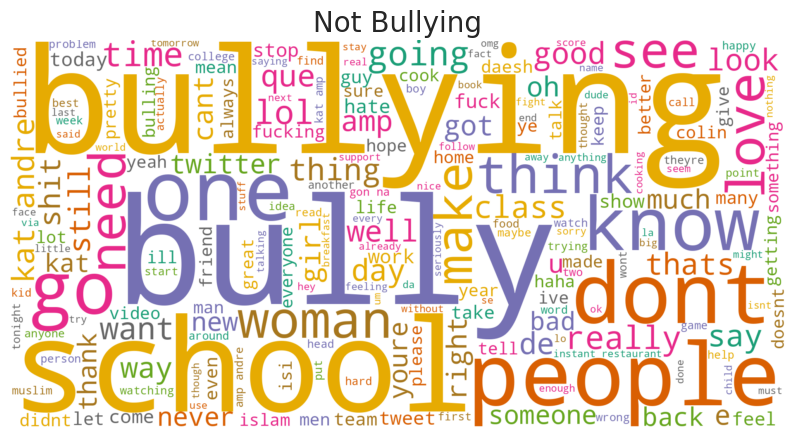

In [38]:
# Not Bullying
plt.figure(figsize=(10, 10))
subset0 = df[df['cyberbullying_type']==0]
text_not = subset0['clean_tweets'].values
wc0 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_not))

plt.axis('off')
plt.title("Not Bullying", fontsize=20)
plt.imshow(wc0, interpolation='bilinear')

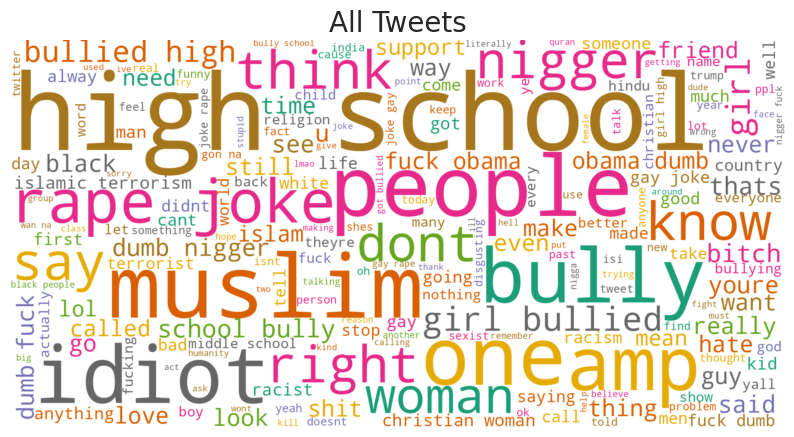

In [39]:
# All Tweets
plt.figure(figsize=(10, 10))
text_all = df['clean_tweets'].values
wc = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_all))

plt.axis('off')
plt.title("All Tweets", fontsize=20)
plt.imshow(wc, interpolation='bilinear')

Checking which words are the most popular

In [40]:
from collections import Counter   # To count the frequency of each word

temp=[]
for tweet in df['clean_tweets']:
  for word in tweet.split():
    temp.append(word)
vocab = Counter(temp)
print("Vocabulary Size:", len(vocab))
print(list(vocab.items())[:5])

Vocabulary Size: 38438
[('word', 867), ('food', 128), ('crapilicious', 1), ('white', 2213), ('classy', 29)]


<br> Plotting

In [41]:
common_word=[]
freq=[]
for i, j in vocab.most_common()[:10]:
  common_word.append(i)
  freq.append(j)

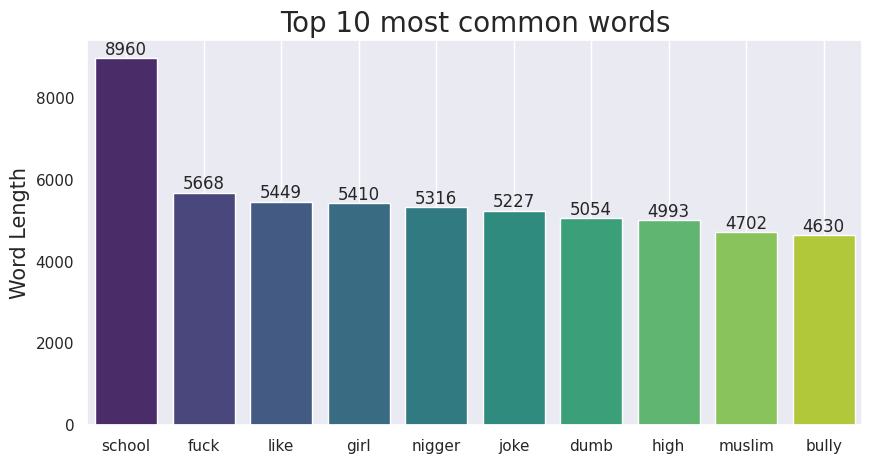

In [42]:
# Most common words
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=common_word, y=freq, palette='viridis')
plt.title('Top 10 most common words', size=20)
ax.bar_label(ax.containers[0])
plt.ylabel("Word Length", size=15)
plt.grid()

## ML Classifiers

Splitting the data into train and test

In [43]:
X = df['clean_tweets']
y = df['cyberbullying_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=76)

**TF-IDF Vectorization**

In [44]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)    # Fit on train
print("No. of feature words:", len(tfidf.get_feature_names_out()))

No. of feature words: 291885


In [45]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)
print(f"{X_train_tf.shape = }\n{X_test_tf.shape = }")

X_train_tf.shape = (30560, 291885)
X_test_tf.shape = (7641, 291885)


Applying models

### ***Logistic Regression***

In [46]:
# Model training
lr = LogisticRegression(solver='saga', penalty='l2', random_state=394)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=394, solver='saga')

In [47]:
# Model prediction
y_pred_train = lr.predict(X_train_tf)
y_pred_test = lr.predict(X_test_tf)

Evaluating the model

In [48]:
# Model evaluation
print('\tClassification Report for Logistic Regression on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Logistic Regression on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Logistic Regression on Train

                    precision    recall  f1-score   support

not_cyberbullying       0.88      0.95      0.91      5814
           gender       0.98      0.91      0.94      5958
         religion       0.98      0.98      0.98      6350
              age       0.98      0.99      0.98      6292
        ethnicity       0.99      0.99      0.99      6146

         accuracy                           0.96     30560
        macro avg       0.96      0.96      0.96     30560
     weighted avg       0.96      0.96      0.96     30560


	Classification Report for Logistic Regression on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.81      0.79      0.80      1454
           gender       0.93      0.85      0.89      1490
         religion       0.95      0.96      0.95      1587
              age       0.92      0.99      0.95      1573
        ethnicity       0.96      0.99      0.97      

The performance scores have an overall accurcy of **92%**.<br>

Text(0.5, 1.0, 'Confusion Matrix LR')

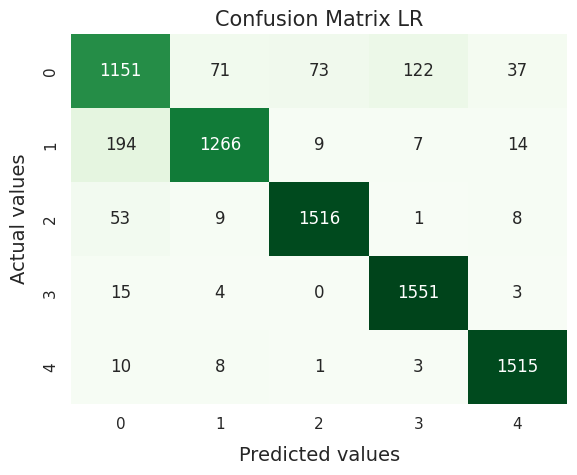

In [49]:
# Confusion Matrix for Logistic Regression
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix LR', size=15)

### ***Naive-Bayes'***

In [50]:
# Model training
mnb = MultinomialNB(alpha=0.1)
mnb.fit(X_train_tf, y_train)

MultinomialNB(alpha=0.1)

In [51]:
# Model prediction
y_pred_train = mnb.predict(X_train_tf)
y_pred_test = mnb.predict(X_test_tf)

In [52]:
# Model evaluation
print('\tClassification Report for Naive-Bayes\' on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Naive-Bayes\' on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Naive-Bayes' on Train

                    precision    recall  f1-score   support

not_cyberbullying       1.00      0.97      0.99      5814
           gender       1.00      0.99      0.99      5958
         religion       0.99      1.00      0.99      6350
              age       0.99      1.00      0.99      6292
        ethnicity       0.99      1.00      1.00      6146

         accuracy                           0.99     30560
        macro avg       0.99      0.99      0.99     30560
     weighted avg       0.99      0.99      0.99     30560


	Classification Report for Naive-Bayes' on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.88      0.48      0.62      1454
           gender       0.87      0.84      0.86      1490
         religion       0.84      0.97      0.90      1587
              age       0.79      0.98      0.88      1573
        ethnicity       0.88      0.94      0.91      1537

        

Text(0.5, 1.0, 'Confusion Matrix NB')

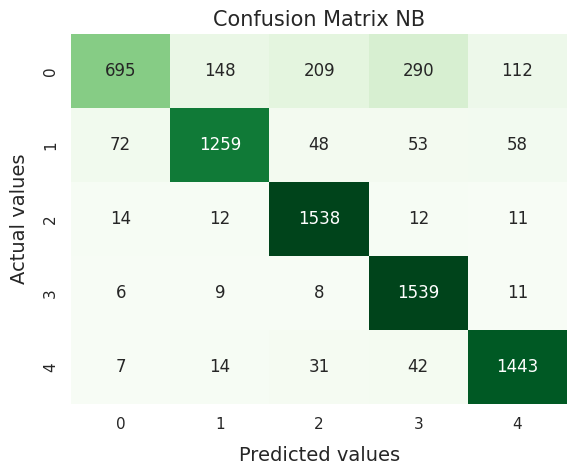

In [53]:
# Confusion Matrix for Naive-Bayes'
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix NB', size=15)

### ***Random Forest***

In [54]:
# Model training
rf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=30, random_state=27)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(criterion='entropy', max_depth=30, random_state=27)

Applied hyperparameter tuning using GridSearchCV below to find the best parameters for our model.

In [55]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': [50, 100, 200],
              'criterion':['gini', 'entropy', 'log_loss'],
              'max_depth': [10, 20, 30, 50],
              }

model = GridSearchCV(estimator=rf, param_grid=parameters)
model.fit(X_train_tf, y_train)
model.best_params_

In [56]:
# Model prediction
y_pred_train = rf.predict(X_train_tf)
y_pred_test = rf.predict(X_test_tf)

In [57]:
# Model evaluation
print('\tClassification Report for Random Forest on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Random Forest on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Random Forest on Train

                    precision    recall  f1-score   support

not_cyberbullying       0.77      0.87      0.82      5814
           gender       0.98      0.77      0.86      5958
         religion       0.94      0.96      0.95      6350
              age       0.93      0.98      0.96      6292
        ethnicity       0.98      0.98      0.98      6146

         accuracy                           0.92     30560
        macro avg       0.92      0.91      0.91     30560
     weighted avg       0.92      0.92      0.91     30560


	Classification Report for Random Forest on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.75      0.82      0.78      1454
           gender       0.96      0.75      0.85      1490
         religion       0.91      0.95      0.93      1587
              age       0.91      0.98      0.94      1573
        ethnicity       0.96      0.97      0.97      1537

      

It reduced the overfitting issue and gave an impressive accuracy of **90%** 

Text(0.5, 1.0, 'Confusion Matrix RF')

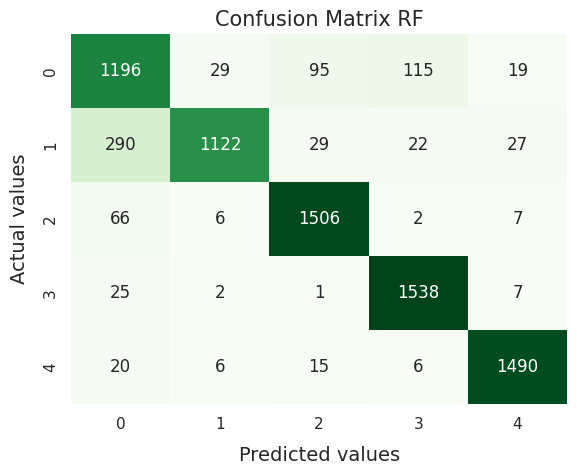

In [58]:
# Confusion Matrix for Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix RF', size=15)

**Ensemble**

Using Voting technique to aggregate the predictions to improve the performance of the model

In [59]:
# Model Training
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators = [('lr', lr), ('mnb', mnb), ('rf', rf)], voting='soft')
vot.fit(X_train_tf, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=394,
                                                 solver='saga')),
                             ('mnb', MultinomialNB(alpha=0.1)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=30,
                                                     random_state=27))],
                 voting='soft')

In [60]:
# Model prediction
y_pred_train = vot.predict(X_train_tf)
y_pred_test = vot.predict(X_test_tf)

In [61]:
# Model evaluation
print('\tClassification Report for Voting on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Voting on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Voting on Train

                    precision    recall  f1-score   support

not_cyberbullying       0.99      0.98      0.98      5814
           gender       1.00      0.99      0.99      5958
         religion       0.99      1.00      0.99      6350
              age       0.99      1.00      1.00      6292
        ethnicity       1.00      1.00      1.00      6146

         accuracy                           0.99     30560
        macro avg       0.99      0.99      0.99     30560
     weighted avg       0.99      0.99      0.99     30560


	Classification Report for Voting on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.86      0.71      0.77      1454
           gender       0.92      0.86      0.89      1490
         religion       0.90      0.98      0.94      1587
              age       0.89      0.99      0.94      1573
        ethnicity       0.95      0.98      0.96      1537

         accuracy   

Text(0.5, 1.0, 'Confusion Matrix Voting')

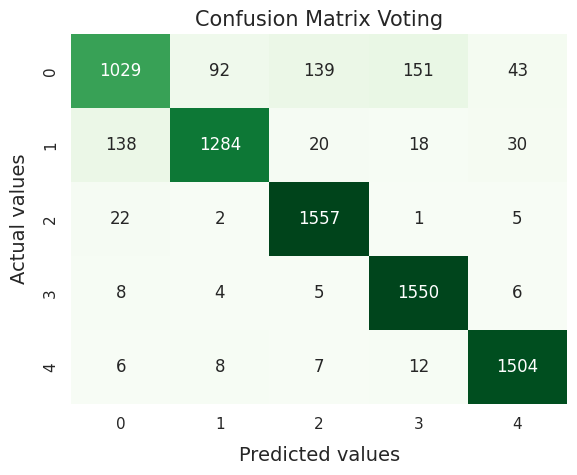

In [62]:
# Confusion Matrix after Voting
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix Voting', size=15)

## Model Saving, Loading and Prediction

In [63]:
# Saving Logistic Regression Model
model_file = open('LogisticRegression.pickle','wb')
pickle.dump(lr, model_file)
model_file.close()

# Saving Naive-Bayes' Model
model_file = open('NaiveBayes.pickle','wb')
pickle.dump(mnb, model_file)
model_file.close()

# Saving Random Forest Model
model_file = open('RandomForest.pickle','wb')
pickle.dump(rf, model_file)
model_file.close()

# Saving our final voting aggregated model
model_file = open('Voting.pickle','wb')
pickle.dump(vot, model_file)
model_file.close()

### **Prediction using saved model**

In [64]:
# Defing our custom prediction function
def predict(model, texts):
    clean_texts = [pre_processing_custom(text) for text in texts]
    text_data = tfidf.transform(clean_texts)
    prediction = model.predict(text_data)

    data = []
    for text, prediction in zip(texts, prediction):
        data.append((text, prediction))

    df = pd.DataFrame(data, columns = ['text','type'])
    df = df.replace([0,1,2,3,4], cyberbullying_type)
    return df

### **Prediction**

In [65]:
# Using our best model
model_file = open('Voting.pickle', 'rb')
model = pickle.load(model_file)
model_file.close()

# Providing some random toxic texts
texts = ["I hate you bitch",
        "School shooting. Haha dead.",
        "Treat them like black slaves",
        "I don't feel so good Mr. Potter",
        "christians are the worst"
        ]

#Our final prediction
predict(model, texts)

,text,type
0,I hate you bitch,gender
1,School shooting. Haha dead.,age
2,Treat them like black slaves,ethnicity
3,I don't feel so good Mr. Potter,not_cyberbullying
4,christians are the worst,religion
